# Analisis de Malware

In [13]:
from pefile import PE

## Analisis estatico

In [14]:
exe_file = PE("./MALWR/sample_vg655_25th.exe")
other_file = PE("./MALWR/sample_qwrty_dk2")

### Utilice la herramienta pefile para examinar el PE header y obtenga las DLL y las APIs que cada uno de los ejecutables utilizan. ¿Qué diferencias observa entre los ejemplos? ¿Existe algún indicio sospechoso en la cantidad de DLLs y las llamadas a APIs?

In [24]:
print('\033[1m Exe file DLLs \033[0m')
for entry in exe_file.DIRECTORY_ENTRY_IMPORT:
    print('  *', entry.dll.decode('ascii'))
print('\033[1m Other file DLLs \033[0m')
for entry in other_file.DIRECTORY_ENTRY_IMPORT:
    print('  *', entry.dll.decode('ascii'))

 Exe file DLLs 
  * KERNEL32.dll
  * USER32.dll
  * ADVAPI32.dll
  * MSVCRT.dll
 Other file DLLs 
  * KERNEL32.DLL
  * MSVCRT.dll
  * SHELL32.dll
  * USER32.dll
  * WS2_32.dll


Como se puede observar en el bloque de código anterior la cantidad de DLLs en cada uno de los archivos difiere en uno al igual que el tipo de DLLs ya que en el caso del archivo .exe se tiene la librería ADVAPI32 y en su lugar en el otro archivo se tiene SHELL32 y WS_32

In [27]:
exe_apis = 0
for entry in exe_file.DIRECTORY_ENTRY_IMPORT:
    print('\033[1m' +  entry.dll.decode('ascii') + '\033[0m')
    for function in entry.imports:
        print('  -', function.name.decode('ascii'))
        exe_apis += 1
print('Llamadas a Apis: ',exe_apis)

KERNEL32.dll
  - GetFileAttributesW
  - GetFileSizeEx
  - CreateFileA
  - InitializeCriticalSection
  - DeleteCriticalSection
  - ReadFile
  - GetFileSize
  - WriteFile
  - LeaveCriticalSection
  - EnterCriticalSection
  - SetFileAttributesW
  - SetCurrentDirectoryW
  - CreateDirectoryW
  - GetTempPathW
  - GetWindowsDirectoryW
  - GetFileAttributesA
  - SizeofResource
  - LockResource
  - LoadResource
  - MultiByteToWideChar
  - Sleep
  - OpenMutexA
  - GetFullPathNameA
  - CopyFileA
  - GetModuleFileNameA
  - VirtualAlloc
  - VirtualFree
  - FreeLibrary
  - HeapAlloc
  - GetProcessHeap
  - GetModuleHandleA
  - SetLastError
  - VirtualProtect
  - IsBadReadPtr
  - HeapFree
  - SystemTimeToFileTime
  - LocalFileTimeToFileTime
  - CreateDirectoryA
  - GetStartupInfoA
  - SetFilePointer
  - SetFileTime
  - GetComputerNameW
  - GetCurrentDirectoryA
  - SetCurrentDirectoryA
  - GlobalAlloc
  - LoadLibraryA
  - GetProcAddress
  - GlobalFree
  - CreateProcessA
  - CloseHandle
  - WaitForSingl

In [29]:
other_apis = 0
for entry in other_file.DIRECTORY_ENTRY_IMPORT:
    print('\033[1m' + entry.dll.decode('ascii') + '\033[0m')
    for function in entry.imports:
        print('  -', function.name)
        other_apis += 1
print('Llamadas a Apis: ', other_apis)

KERNEL32.DLLentry.dll
  - b'LoadLibraryA'
  - b'ExitProcess'
  - b'GetProcAddress'
  - b'VirtualProtect'
MSVCRT.dllentry.dll
  - b'atol'
SHELL32.dllentry.dll
  - b'SHChangeNotify'
USER32.dllentry.dll
  - b'LoadStringA'
WS2_32.dllentry.dll
  - b'closesocket'
Llamadas a Apis:  8


Al obtener la llamada a las APIs se puede observar una diferencia significativa en la cantidad de APIs que llama cada uno de los archivos, ya que en el caso del archivo .exe realiza 144 llamadas a API mientras que el otro archivo únicamente realiza 8 llamadas, recordemos que una poca cantidad de llamadas a APIs puede ser un indicio de un malware que se encuentra empaquetado ocultándo las llamadas que puedieran facilitar su reconocimiento.

Por su parte, algo interesante a observar en es el hecho de que dentro del archivo .exe se está utilizando la biblioteca ADVAPI32.dll la cual suele hacer llamadas de seguirdad y de registros. A su vez, dentro de este dll se puede observar que se crea o abre (si esta ya esxiste) una llave de registro. Las llaves de registro en Windows son unidades organizacionales utilizadas para guardar información de configuración. A su vez, se debe de tomar en consideración que modificaciones a los registros que ocasionen errores de sintaxis pueden hacer que el sistema se vuelva inoperable, por lo cual es un indicio que el ejecutable analizado puede estar haciendo operaciones "raras" en el sistema operativo. 

### Obtenga la información de las secciones del PE Header. ¿Qué significa que algunas secciones tengan como parte de su nombre “upx”? Realice el procedimiento de desempaquetado para obtener las llamadas completas de las APIs.

In [34]:
print('\033[1m Exe file Sections \033[0m')
for section in exe_file.sections:
    print('  ' + section.Name.decode('ascii'))

 Exe file Sections 
  .text   
  .rdata  
  .data   
  .rsrc   


In [35]:
print('\033[1m Other file Sections \033[0m')
for section in other_file.sections:
    print('   ' + section.Name.decode('ascii'))

 Other file Sections 
   UPX0    
   UPX1    
   .rsrc   


En en el análisis de las secciones de los ejecutables se pudo observar como el archivo con extensión .exe cuenta con las secciones normales de un archivo PE las cuales son la sección de texto, datos, recursos y memoria (reloc). Sin embargo, en el caso del otro archivo se puede observar que sus secciones inician con UPX.. esto se debe a que el ejecutable se encuentra empaquetado mediante UPX. Para poder al *header* del ejecutable original será necesario desempaquetarlo.

In [2]:
!cp ./MALWR/sample_qwrty_dk2 ./MALWR/sample_qwrty_dk2_executable

In [3]:
!upx -d ./MALWR/sample_qwrty_dk2_executable

                       Ultimate Packer for eXecutables
                          Copyright (C) 1996 - 2020
UPX 3.96        Markus Oberhumer, Laszlo Molnar & John Reiser   Jan 23rd 2020

        File size         Ratio      Format      Name
   --------------------   ------   -----------   -----------
      8192 <-      5632   68.75%    win32/pe     sample_qwrty_dk2_executable

Unpacked 1 file.


In [38]:
executable_unpackage = PE("./MALWR/sample_qwrty_dk2_executable")
unpackage = 0
for entry in executable_unpackage.DIRECTORY_ENTRY_IMPORT:
    print('\033[1m' + entry.dll.decode('ascii') + '\033[0mentry.dll')
    for function in entry.imports:
        print('  -', function.name.decode('ascii'))
        unpackage += 1
print('Llamadas a Apis: ', unpackage)

KERNEL32.DLLentry.dll
  - CloseHandle
  - WaitForSingleObject
  - CreateEventA
  - ExitThread
  - Sleep
  - GetComputerNameA
  - CreatePipe
  - DisconnectNamedPipe
  - TerminateProcess
  - WaitForMultipleObjects
  - TerminateThread
  - CreateThread
  - CreateProcessA
  - DuplicateHandle
  - GetCurrentProcess
  - ReadFile
  - PeekNamedPipe
  - SetEvent
  - WriteFile
  - SetProcessPriorityBoost
  - SetThreadPriority
  - GetCurrentThread
  - SetPriorityClass
  - lstrcatA
  - lstrcpyA
  - GetEnvironmentVariableA
  - GetShortPathNameA
  - GetModuleFileNameA
  - GetStartupInfoA
  - GetModuleHandleA
MSVCRT.dllentry.dll
  - _controlfp
  - _beginthread
  - _strnicmp
  - sprintf
  - atol
  - strchr
  - free
  - malloc
  - _exit
  - _XcptFilter
  - exit
  - _acmdln
  - __getmainargs
  - _initterm
  - __setusermatherr
  - _adjust_fdiv
  - __p__commode
  - __p__fmode
  - __set_app_type
  - _except_handler3
  - _itoa
SHELL32.dllentry.dll
  - ShellExecuteExA
  - SHChangeNotify
USER32.dllentry.dll
  -

Al desempaquetar el archivo se pueden observar llamadas que en el apartado anterior no se mostraban debido al empaquetado, algo interesante de una de las llamadas realizadas ocurre en el dll WS2_32 ya que tiene llamadas a APIs que parecen estar relacionadas con conecciones, investigando un poco más se pudo encontrar que WS2_32.dll es una librería dinámica encargada de "manejar" conecciones de red y regularmente es utilizado como un caballo de Troya.

### Según el paper “Towards Understanding Malware Behaviour by the Extraction of API Calls”, ¿en que categoría sospechosas pueden clasificarse estos ejemplos en base a algunas de las llamadas a las APIs que realizan? Muestre una tabla con las APIs sospechosas y la categoría de malware que el paper propone.

Con base en el paper el archivo ejecutable puede clasificarse en 3 categorías
| Categoría            | Llamadas a APIs                                                                        |
|----------------------|----------------------------------------------------------------------------------------|
| Copy/Delete Files    | Close Handle, CopyFileA                                                                |
| Get File Information | GetFileAttributesW, GetFileSizeEx, GetTempPathW,  GetFileAttributesA, GetFullPathNameA |
| Read/Write Files     | WriteFile, CreateFile, CloseHandle                                                     |

De igual forma, según el paper el archivo originalmente empaquetado se puede clasificar vagamente en 3 categorías
| Categoría            | Llamadas a APIs        |
|----------------------|------------------------|
| Copy/Delete Files    | Close Handle           |
| Get File Information | GetShortPathNameA      |
| Read/Write Files     | WriteFile, CloseHandle |


### Para el archivo “sample_vg655_25th.exe” obtenga el HASH en base al algoritmo SHA256.

In [11]:
!sha256sum ./MALWR/sample_vg655_25th.exe

ed01ebfbc9eb5bbea545af4d01bf5f1071661840480439c6e5babe8e080e41aa  ./MALWR/sample_vg655_25th.exe


### Para el archivo “sample_vg655_25th.exe”, ¿cuál es el propósito de la DLL ADVAPI32.dll?

Tal como se explicó anteriormente, ADVAPI32 provee llamadas de seguridad y funciones para la modificación de los registros de Windows, tal como crear nuevas llaves de registro, abrir las existentes y hacer modificaciones a las mismas. 

### Para el archivo “sample_vg655_25th.exe”, ¿cuál es el propósito de la API CryptReleaseContext?

Según Microsoft, CrypReleaseContext "libera" el identificados de un proveedor de servicios criptográficos y un contenedor de claves anteriormente utilizado. Hay que tomar en cuenta que una vez que se libera el identificador tanto el contenedor de llaves como todas las parejas de claves que se hayan generado serán destruídas y a su vez, el identificador ya no será válido. Una analogía para el propósito de esta API puede ser al momento de usar punteros en algún lenguaje de progamación, de cierta manera al liberar la memoria, se está "liberando" el identificador y al igual que en este caso, el puntero ya no puede ser accedido porque ya no existe, el servicio criptográfico tampoco puede utilizarse más.

### Con la información recopilada hasta el momento, indique para el archivo “sample_vg655_25th.exe” si es sospechoso o no, y cual podría ser su propósito.

Con base en la información anterior se puede decir que uno de los comportamientos más predominantes de este archivo es el obtener información de los archivos, y al analizar el resto de APIs espcialmente aquellas que se encuentran en ADVAPI32.dll con todas las llamadas a APIs para crear o modificar llaves de registros y a su vez libera servicios criptográficos se puede inferir que el archivo sí es sospechoso y se encarga de encriptar los archivos de un ordenador.

## Análisis dinámico

### Utilice la plataforma de análisis dinámico https://www.hybrid-analysis.com y cargue el archivo “sample_vg655_25th.exe”. ¿Se corresponde el HASH de la plataforma con el generado? ¿Cuál es el nombre del malware encontrado? ¿Cuál es el propósito de este malware?

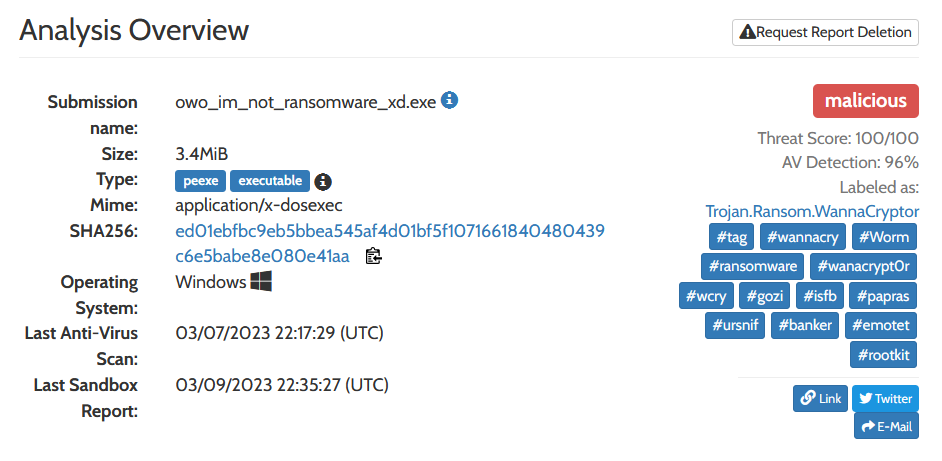

Como se puede observar en la imagen anterior en el apartado de SHA256 este conindice con el encontrado en el análisis estático mediante SHA256. De igual forma se puede encontrar que el nombre del malware es Trojan.Ransom.WannaCryptor, el propósito de este malware es encriptar los archivos de un ordenador y luego solicita un pago para recuperar la información de los mismos.

### Muestre  las  capturas  de  pantalla  sobre  los  mensajes  que  este  malware  presenta  a  un usuario ¿Se corresponden las sospechas con el análisis realizado en el punto 7? 

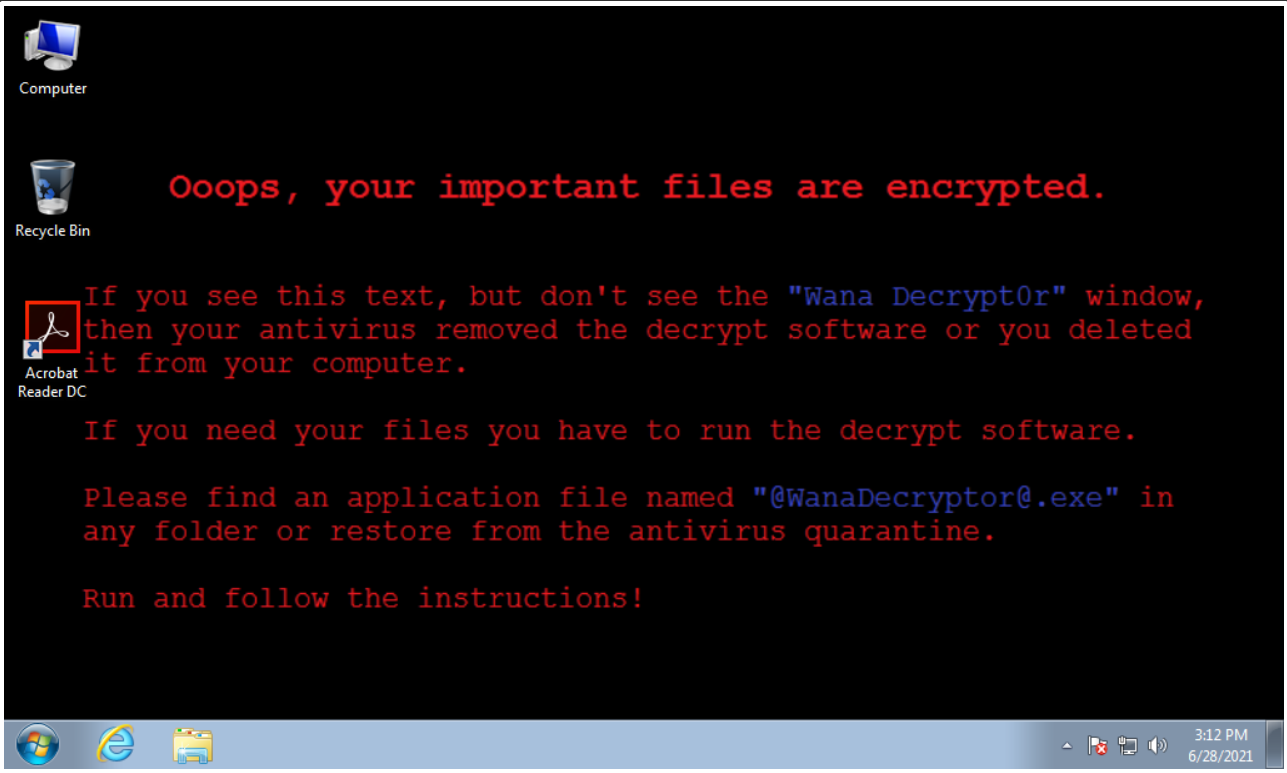

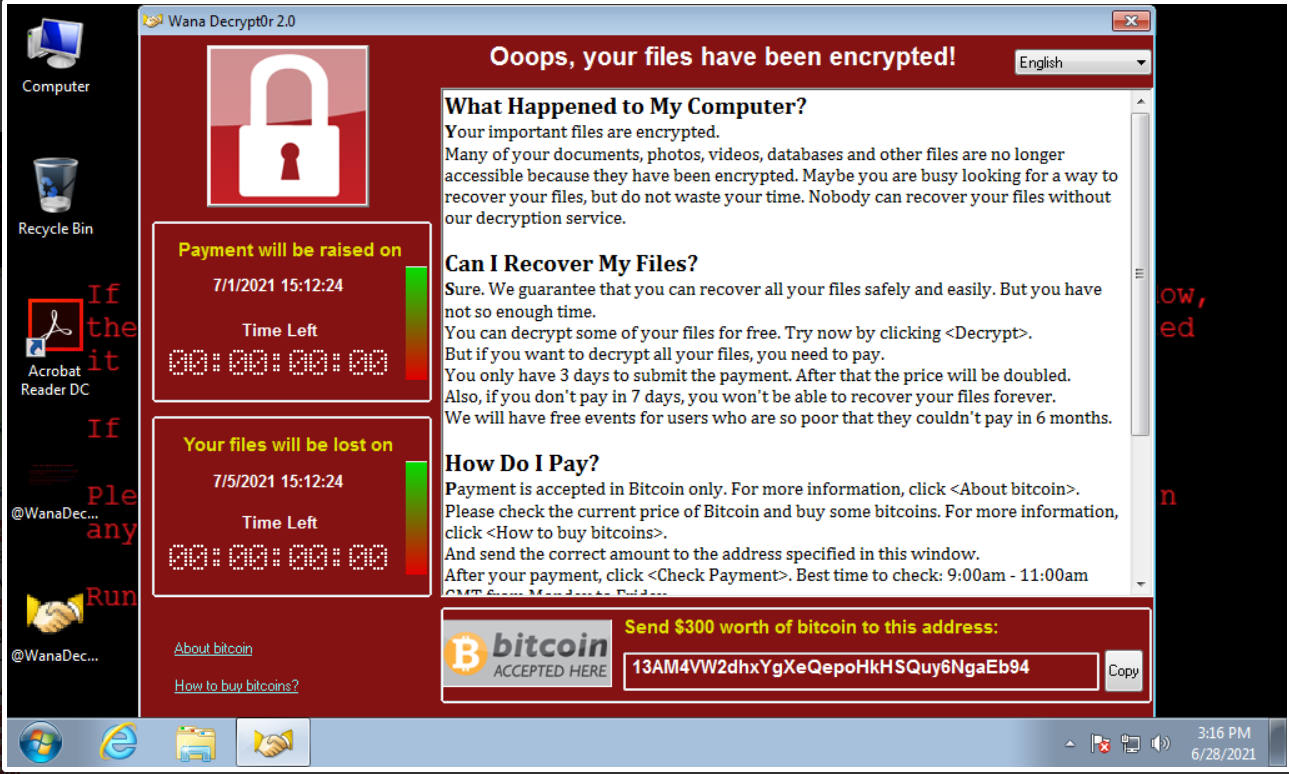

Como se puede observar en las imágenes anteriores, y tal como se describió en la el apartado anterior, el malware corresponde a un tipo de ransomware, lo cual coincide con el análisis realizado en el apartado 7 ya que el malware busca los archivos del usuario y se encarga de encriptarlos para luego solicitar un pago por la recuperación de la información. 